In [1]:
import numpy as np 
import pandas as pd
import yaml
import pandas as pd
import torch
from IPython.display import Image
from shutil import copy
import matplotlib.pyplot as plt 
%matplotlib inline
import os

In [2]:
!git clone https://github.com/ultralytics/yolov5.git  

Cloning into 'yolov5'...
remote: Enumerating objects: 14927, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 14927 (delta 7), reused 12 (delta 2), pack-reused 14908
Receiving objects: 100% (14927/14927), 13.95 MiB | 18.29 MiB/s, done.
Resolving deltas: 100% (10251/10251), done.


In [3]:
os.chdir('/content/yolov5')
%pip install -qr requirements.txt 
os.chdir('/content')
!pwd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.4 MB/s eta 0:00:00
/content


In [4]:
!mkdir /content/yolov5/data_images/
!mkdir /content/yolov5/data_images/test/
!mkdir /content/yolov5/data_images/train/

In [5]:
yaml_dict = {'train': 'data_images/train',  
            'val': 'data_images/test', 
            'nc': 1,                            
            'names': ['plate']} 

with open(r'/content/yolov5/plate_detection.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [6]:
!unzip /content/drive/MyDrive/image_files.zip

Archive:  /content/drive/MyDrive/image_files.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annota

In [7]:
import xml.etree.ElementTree as ET

annotation_df = pd.DataFrame(columns = ['FileName', 'xmin','ymin','xmax','ymax',
                                        'width','height'])


path_xml = '/content/annotations'
for filename in os.listdir(path_xml):
    annotation_list = []
    tree = ET.parse(os.path.join(path_xml,filename))
    root = tree.getroot()
    annotation_list.append(root.find('filename').text)
    #print(root.find('filename').text)
    for cord in root.find('object').find('bndbox'):
        annotation_list.append(int(cord.text))
    annotation_list.append(int(root.find('size').find('width').text))
    annotation_list.append(int(root.find('size').find('height').text))
    annotation_df.loc[len(annotation_df)] = annotation_list
annotation_df

,FileName,xmin,ymin,xmax,ymax,width,height
0,Cars217.png,149,196,223,231,400,240
1,Cars255.png,116,156,273,188,400,267
2,Cars248.png,184,143,311,191,400,300
3,Cars169.png,114,79,229,101,400,200
4,Cars289.png,163,140,271,173,400,307
...,...,...,...,...,...,...,...
428,Cars32.png,200,149,251,167,400,300
429,Cars362.png,139,172,162,179,400,300
430,Cars411.png,160,153,249,197,400,268
431,Cars21.png,191,165,255,192,400,301


In [8]:
['center_x','center_y','bb_width','bb_height']
annotation_df['center_x'] = (annotation_df['xmax'] + annotation_df['xmin'])/(2*annotation_df['width'])
annotation_df['center_y'] = (annotation_df['ymax'] + annotation_df['ymin'])/(2*annotation_df['height'])

annotation_df['bb_width'] = (annotation_df['xmax'] - annotation_df['xmin'])/annotation_df['width']
annotation_df['bb_height'] = (annotation_df['ymax'] - annotation_df['ymin'])/annotation_df['height']
annotation_df.head()

,FileName,xmin,ymin,xmax,ymax,width,height,center_x,center_y,bb_width,bb_height
0,Cars217.png,149,196,223,231,400,240,0.465,0.889583,0.185,0.145833
1,Cars255.png,116,156,273,188,400,267,0.48625,0.644195,0.3925,0.11985
2,Cars248.png,184,143,311,191,400,300,0.61875,0.556667,0.3175,0.16
3,Cars169.png,114,79,229,101,400,200,0.42875,0.45,0.2875,0.11
4,Cars289.png,163,140,271,173,400,307,0.5425,0.509772,0.27,0.107492


In [9]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(annotation_df, test_size=0.15)
[len(df_train),len(df_test)]

[368, 65]

In [10]:
train_folder = '/content/yolov5/data_images/train'
values = df_train[['FileName','center_x','center_y','bb_width','bb_height']].values

In [11]:
rain_folder = '/content/yolov5/data_images/train'
values = df_train[['FileName','center_x','center_y','bb_width','bb_height']].values
for fname, x, y, w, h in values:
    label_txt = f'0 {x} {y} {w} {h}'
    copy(os.path.join('/content/images',fname),
         os.path.join(train_folder,fname))
    fname_ = fname.split('.')[0]
    label_path = os.path.join(train_folder,fname_+'.txt')
    with open(label_path, mode='w') as f:
        f.write(label_txt)
        f.close()

In [12]:
test_folder = '/content/yolov5/data_images/test'
values = df_test[['FileName','center_x','center_y','bb_width','bb_height']].values
for fname, x, y, w, h in values:
    label_txt = f'0 {x} {y} {w} {h}'
    copy(os.path.join('/content/images',fname),
         os.path.join(test_folder,fname))
    fname_ = fname.split('.')[0]
    label_path = os.path.join(test_folder,fname_+'.txt')
    with open(label_path, mode='w') as f:
        f.write(label_txt)
        f.close()

In [35]:
!python ./yolov5/train.py --data /content/yolov5/plate_detection.yaml --cfg ./yolov5/models/yolov5s.yaml --workers 0 --batch-size 8 --name Model --epochs 50

train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=/content/yolov5/plate_detection.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, 

In [36]:
!python /content/yolov5/detect.py --source /content/test_img3.png --weights /content/yolov5/runs/train/Model2/weights/best.pt --data /content/yolov5/plate_detection.yaml

detect: weights=['/content/yolov5/runs/train/Model2/weights/best.pt'], source=/content/test_img3.png, data=/content/yolov5/plate_detection.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/test_img3.png: 416x640 1 plate, 19.5ms
Speed: 0.5ms pre-process, 19.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/detect/exp9


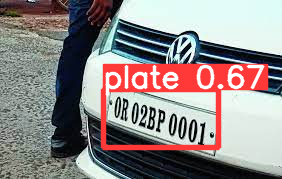

In [37]:
Image(filename='/content/yolov5/runs/detect/exp9/test_img3.png', width=416)

In [38]:
!python /content/yolov5/export.py --weights /content/yolov5/runs/train/Model2/weights/best.pt --include tflite --int8 --img 416 --data /content/yolov5/plate_detection.yaml

export: data=/content/yolov5/plate_detection.yaml, weights=['/content/yolov5/runs/train/Model2/weights/best.pt'], imgsz=[416], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=True, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite']
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/Model2/weights/best.pt with output shape (1, 10647, 6) (13.7 MB)

TensorFlow SavedModel: starting export with tensorflow 2.9.2...

                 from  n    params  module                                  arguments                     
2023-01-05 20:13:50.177112: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device

In [39]:
!python /content/yolov5/detect.py --source /content/test_img2.png --img 416  --weights /content/yolov5/runs/train/Model2/weights/best-int8.tflite --data /content/yolov5/plate_detection.yaml

detect: weights=['/content/yolov5/runs/train/Model2/weights/best-int8.tflite'], source=/content/test_img2.png, data=/content/yolov5/plate_detection.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Loading /content/yolov5/runs/train/Model2/weights/best-int8.tflite for TensorFlow Lite inference...
image 1/1 /content/test_img2.png: 416x416 1 plate, 163.5ms
Speed: 2118.8ms pre-process, 163.5ms inference, 2.2ms NMS per image at shape (1, 3, 416, 416)
Results saved to yolov5/runs/detect/exp10


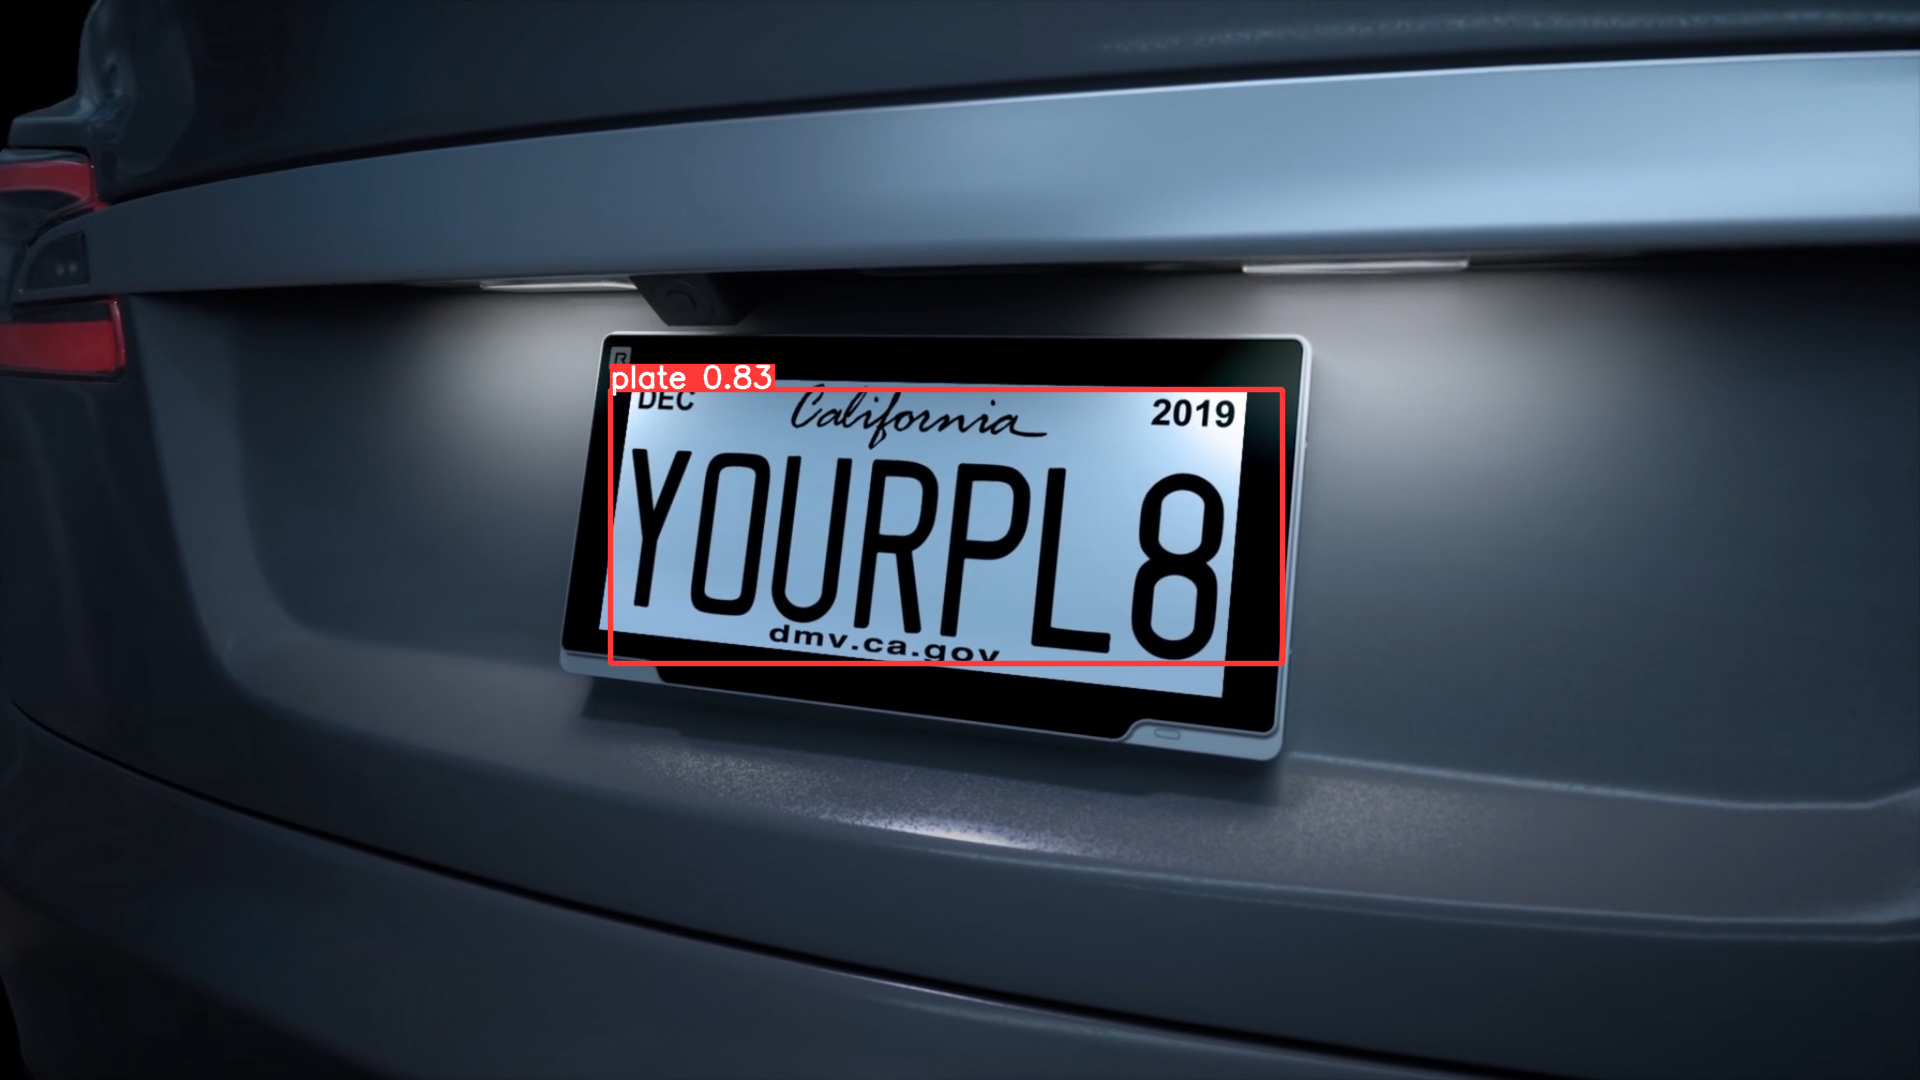

In [40]:
Image(filename='/content/yolov5/runs/detect/exp10/test_img2.png', width=416)